In [ ]:
import torch
import time
from data.num_solver_exciton import NZSolverEx
from data.num_solver_biexciton import NZSolverBiex
from train import train_nz_pinn

Using device: cpu


Solving Nakajima-Zwanzig EOM for Exciton model: 100%|██████████| 301/301 [00:20<00:00, 14.98it/s]


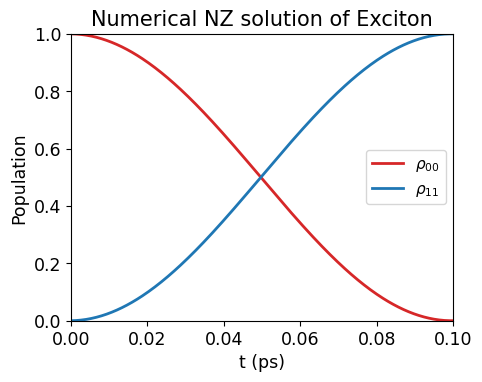

In [7]:
nz_ex = NZSolverEx(D=0.1,steps=300,T=10)
times, rhos = nz_ex.solve(torch.tensor([[1.0, 0.0], [0.0, 0.0]], dtype=torch.cfloat))

rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])

# Plot dynamics
nz_ex.plot_results(times, rhos)


Solving Nakajima-Zwanzig EOM for Biexciton model: 100%|██████████| 301/301 [00:22<00:00, 13.42it/s]

Time taken: 22.4 seconds


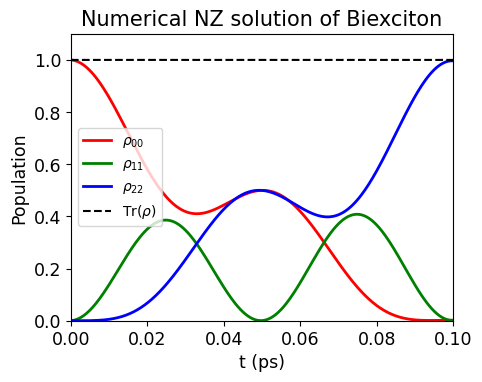

In [9]:
# Initial density matrix
rho_init = torch.diag(torch.tensor([1.0, 0.0, 0.0], dtype=torch.cfloat))

nz_biex = NZSolverBiex(D=0.1, steps=300, A=0.0112, omega_c=3.04, T=10)

start = time.time()
times, rhos = nz_biex.solve(rho_init)
end = time.time()
print(f"Time taken: {round(end - start, 1)} seconds")

# Plot dynamics
nz_biex.plot_results(times, rhos)


Epoch: 0  |  Loss = 9.58153e-01


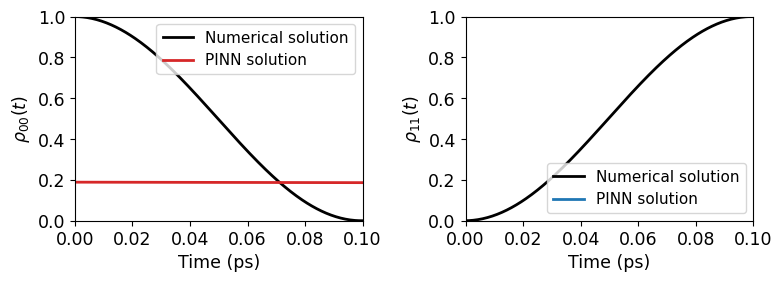

Epoch: 100  |  Loss = 1.90940e-02


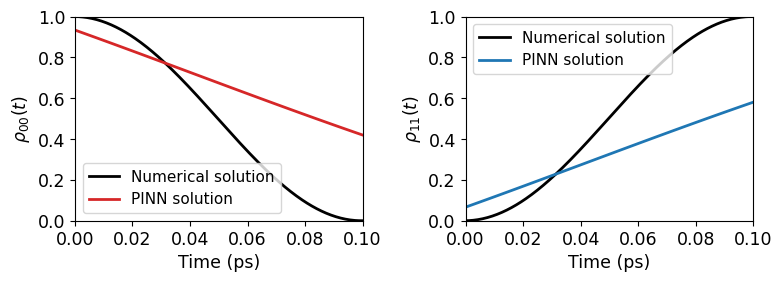

Epoch: 200  |  Loss = 6.67642e-03


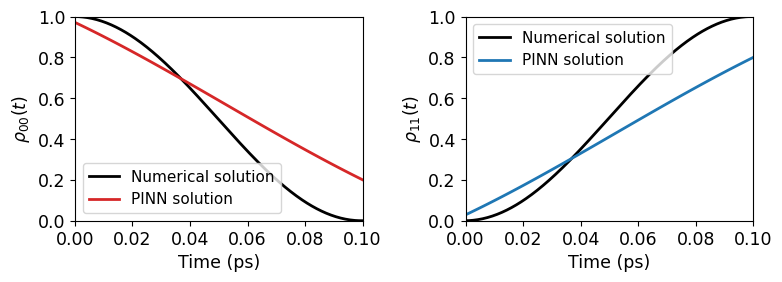

Epoch: 300  |  Loss = 2.92555e-03


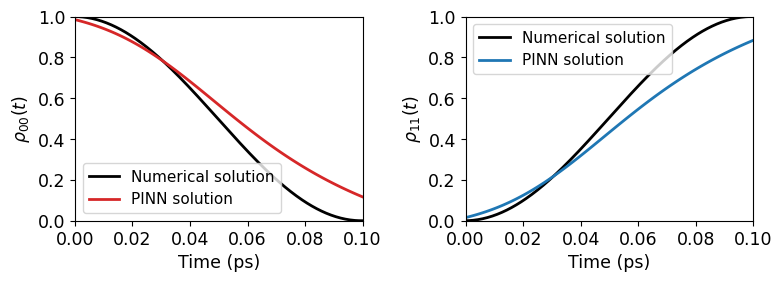

Epoch: 400  |  Loss = 8.64187e-04


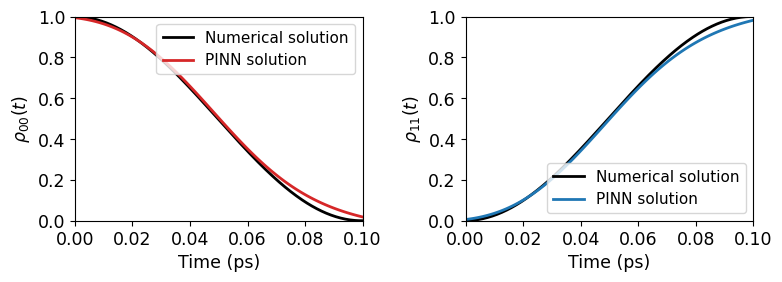

Epoch: 500  |  Loss = 1.43687e-04


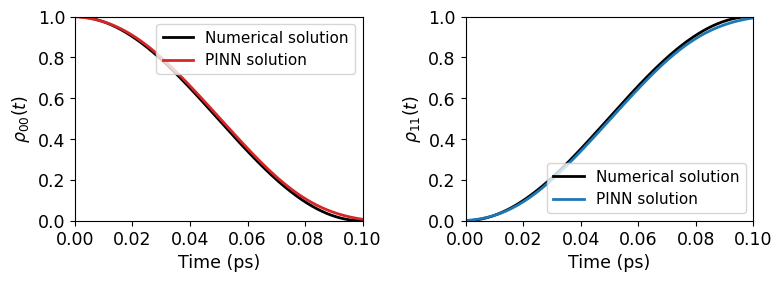

Time elapsed:  2.731441307067871 min


In [8]:
# Diagonalize the numerically solved density matrices
rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])

start = time.time()
ex_model = train_nz_pinn(sys='e', t=times, rho_diag=rho_diag, D=0.1, t_intervals = 20, A=0.0112, T=10, omega_c=3.04,
                    n_layers=4, n_hidden=32, epochs=501, lr=1e-2, lam=0.001, plot_interval=100)
end = time.time()

print(f"Time elapsed:  {(end-start)/60} min")

Epoch: 0  |  Loss = 4.55212e-01


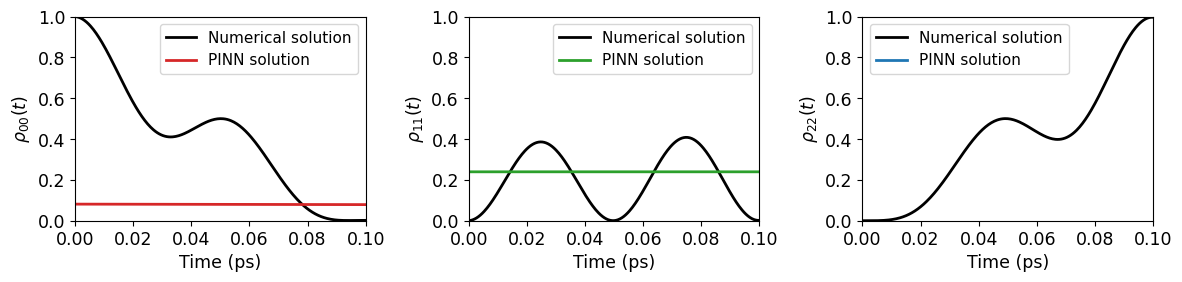

Epoch: 500  |  Loss = 1.34298e-03


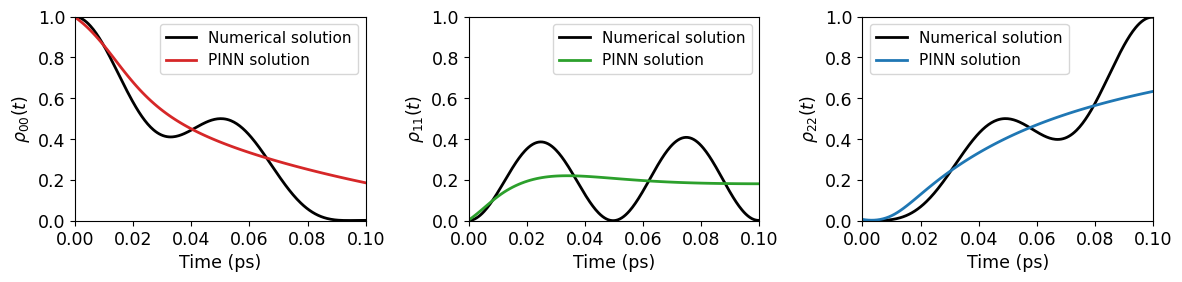

Epoch: 1000  |  Loss = 5.64765e-04


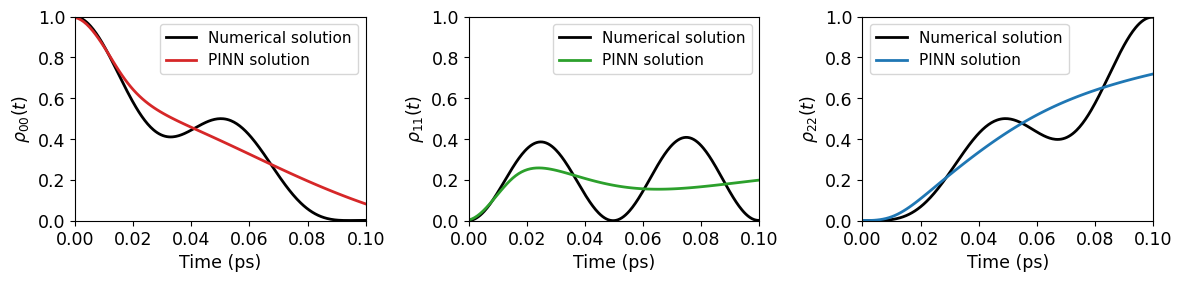

Epoch: 1500  |  Loss = 4.26776e-04


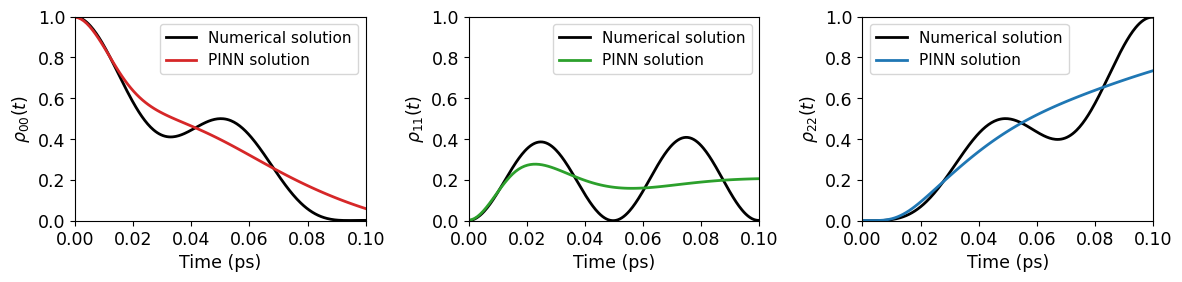

Epoch: 2000  |  Loss = 3.21696e-04


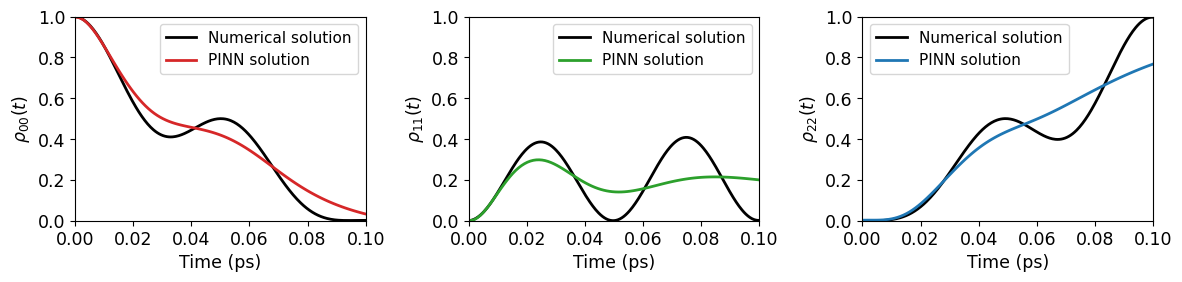

Epoch: 2500  |  Loss = 1.97385e-04


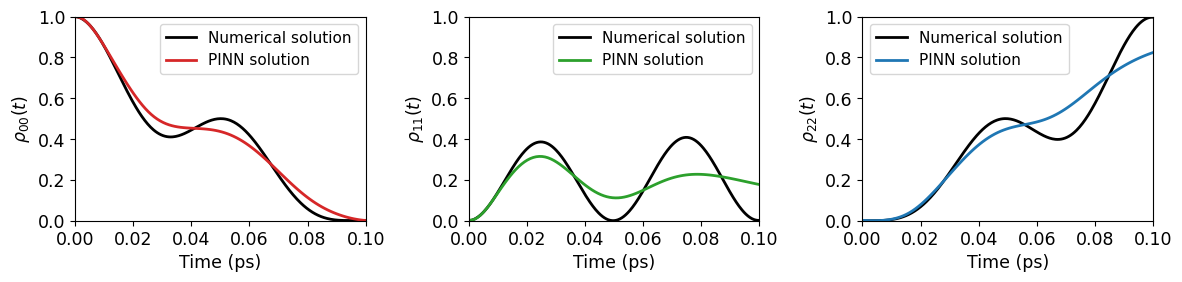

Epoch: 3000  |  Loss = 1.21682e-04


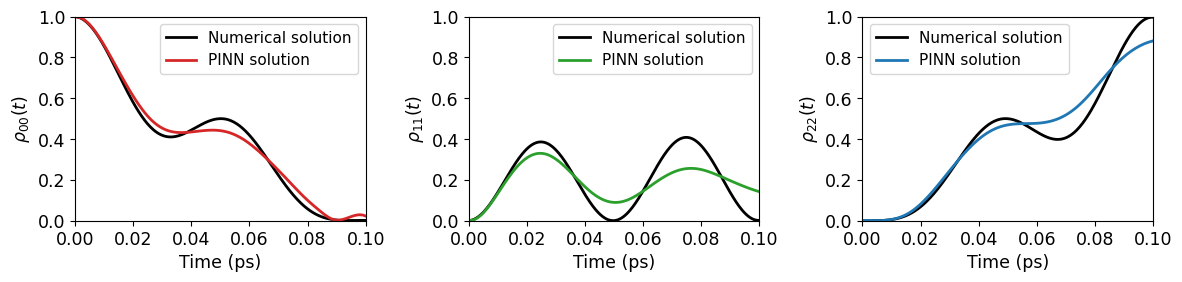

Epoch: 3500  |  Loss = 9.51783e-05


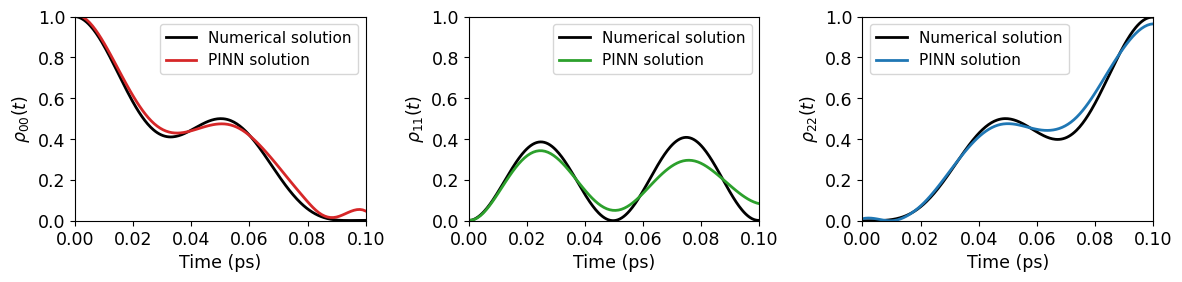

Epoch: 4000  |  Loss = 1.13714e-04


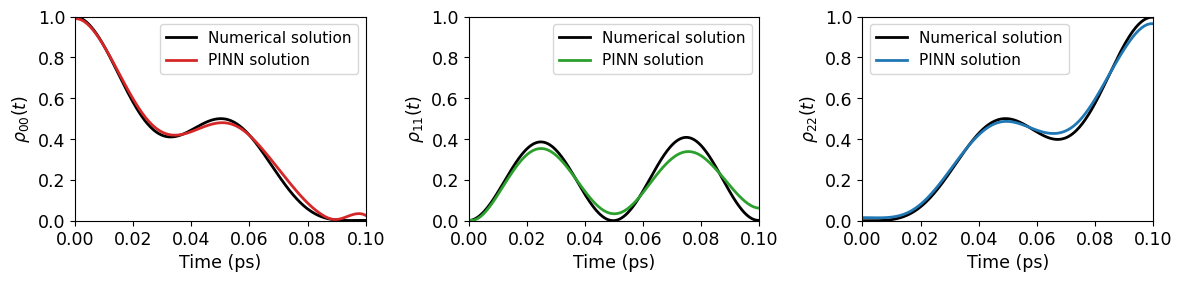

Epoch: 4500  |  Loss = 1.36329e-05


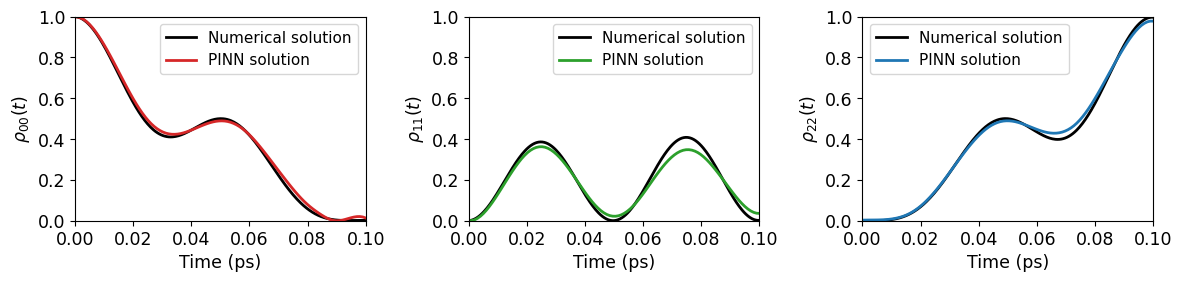

Epoch: 5000  |  Loss = 1.81170e-04


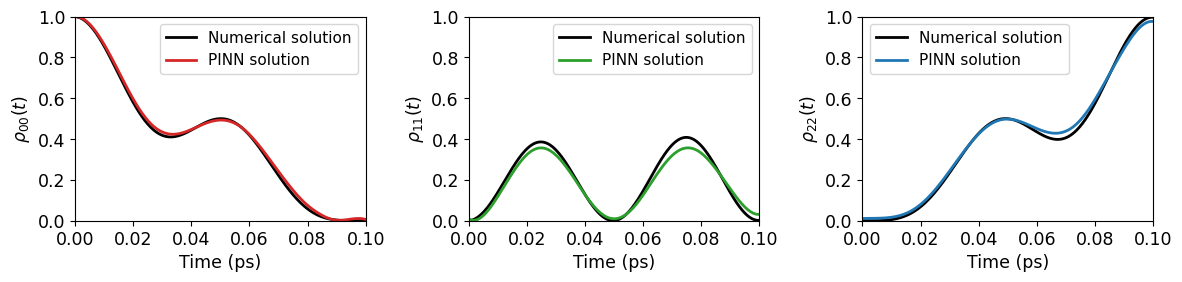

Epoch: 5500  |  Loss = 5.49243e-06


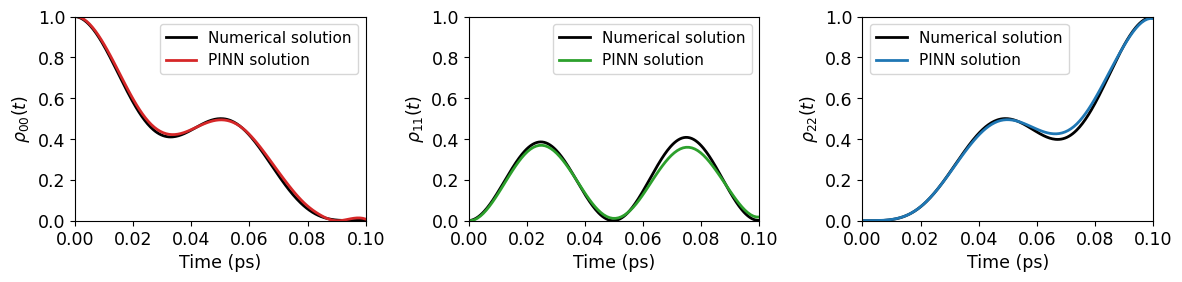

Time elapsed:  37.26981825033824 min


In [10]:
# Diagonalize the numerically solved density matrices
rho_diag = torch.stack([torch.real(torch.diag(rho)) for rho in rhos])
start = time.time()
biex_model = train_nz_pinn(sys='b', t=times, rho_diag=rho_diag, D=0.1, t_intervals=20, A=0.0112, T=10, omega_c=3.04,
                    n_layers=4, n_hidden=32, epochs=5501, lr=1e-2, lam=0.0001, plot_interval=500)
end = time.time()
print(f"Time elapsed:  {(end-start)/60} min")